# **D3APL: Aplicações em Ciência de Dados - IFSP Campinas**

**Professor:** Dr. Samuel Martins (Samuka)

**Alunos:**

* Gabrielly Baratela de Carvalho (CP3016331)
* Halisson Gomides de Souza (CP3016382)
* Hugo Martinelli Watanuki (CP3016692)

# **Celebrity Face Recognition Competition**

The objetive of this notebook is to document and provide the python code required to address a specific problem of computer vision: the recognition of the faces of celebrities contained in a public dataset ([http://www.briancbecker.com/blog/research/pubfig83-lfw-dataset/](http://))

This notebook is structured in four main sections that also represent the main steps adopted to address the problem:
1. Profiling the dataset
1. Defining a model and preprocessing the images
1. Training and fine-tuning the model
1. Final prediction and concluding remarks

The main approach adopted to address the problem involved addressing the class imbalance of the training dataset, preprocessing the images and the leveraging of a pre-trained face recognition model for transfer learning.

In [2]:
# Note 1:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Note 2:
# Allocating memory on demand
# By default TensorFlow allocates GPU memory for the lifetime of a process, not the lifetime of the session object (so memory can linger much longer than the object). That is why memory is lingering after you stop the program.
# Instead, we can indicate to TensorFlow allocates memory on demand.

# Importing and checking Tensorflow version
import tensorflow as tf
tf.__version__

# Checking for GPU availability
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Managing GPU memory growth
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


# 1. Profiling the Dataset

The objetive of this step is to understand the dataset structure, handle the class imbalance and generating a dataframe.

In [23]:
# Listing important libraries required for profiling
import cv2
import glob  
import matplotlib.pyplot as plt
import os
import pandas as pd
import random

## 1.1 The Dataset

The dataset utilized in this competition is a combination of the [PubFigg83](http://vision.seas.harvard.edu/pubfig83/) and [LFW](http://vis-www.cs.umass.edu/lfw/).

The dataset has 13,840 color images of 83 celebrities and has been previously reshaped to a 100x100 pixels dimension according to the position of the eyes of the individual in the image. 12,1280 images compose the labeled training dataset and 1,660 unlabeled images compose the test dataset. 

The dataset is located on the '/kaggle/input/' directory of the current kernel.

In [5]:
# Defining the dataset_folder and evaluating the number of classes
dataset_folder = '../input/ifsp-d3apl-2023-face-recognition/train/train/'

class_folders = sorted(os.listdir(dataset_folder))

print(class_folders)
print(f'Number of class: {len(class_folders)}')

['Adam Sandler', 'Alec Baldwin', 'Angelina Jolie', 'Anna Kournikova', 'Ashton Kutcher', 'Avril Lavigne', 'Barack Obama', 'Ben Affleck', 'Beyonce Knowles', 'Brad Pitt', 'Cameron Diaz', 'Cate Blanchett', 'Charlize Theron', 'Christina Ricci', 'Claudia Schiffer', 'Clive Owen', 'Colin Farrell', 'Colin Powell', 'Cristiano Ronaldo', 'Daniel Craig', 'Daniel Radcliffe', 'David Beckham', 'David Duchovny', 'Denise Richards', 'Drew Barrymore', 'Dustin Hoffman', 'Ehud Olmert', 'Eva Mendes', 'Faith Hill', 'George Clooney', 'Gordon Brown', 'Gwyneth Paltrow', 'Halle Berry', 'Harrison Ford', 'Hugh Jackman', 'Hugh Laurie', 'Jack Nicholson', 'Jennifer Aniston', 'Jennifer Lopez', 'Jennifer Love Hewitt', 'Jessica Alba', 'Jessica Simpson', 'Joaquin Phoenix', 'John Travolta', 'Julia Roberts', 'Julia Stiles', 'Kate Moss', 'Kate Winslet', 'Katherine Heigl', 'Keira Knightley', 'Kiefer Sutherland', 'Leonardo DiCaprio', 'Lindsay Lohan', 'Mariah Carey', 'Martha Stewart', 'Matt Damon', 'Meg Ryan', 'Meryl Streep', '

In [6]:
# Evaluating the class proportions: number of samples per class
for class_folder in class_folders:
    full_class_folder = os.path.join(dataset_folder, class_folder)
    
    class_img_filenames = os.listdir(full_class_folder)
    print(f'Number of Images for Class "{class_folder}": {len(class_img_filenames)}')

Number of Images for Class "Adam Sandler": 88
Number of Images for Class "Alec Baldwin": 83
Number of Images for Class "Angelina Jolie": 194
Number of Images for Class "Anna Kournikova": 151
Number of Images for Class "Ashton Kutcher": 81
Number of Images for Class "Avril Lavigne": 279
Number of Images for Class "Barack Obama": 249
Number of Images for Class "Ben Affleck": 97
Number of Images for Class "Beyonce Knowles": 106
Number of Images for Class "Brad Pitt": 280
Number of Images for Class "Cameron Diaz": 226
Number of Images for Class "Cate Blanchett": 140
Number of Images for Class "Charlize Theron": 175
Number of Images for Class "Christina Ricci": 123
Number of Images for Class "Claudia Schiffer": 102
Number of Images for Class "Clive Owen": 114
Number of Images for Class "Colin Farrell": 125
Number of Images for Class "Colin Powell": 92
Number of Images for Class "Cristiano Ronaldo": 148
Number of Images for Class "Daniel Craig": 148
Number of Images for Class "Daniel Radclif

In [7]:
# Sorting and identifying the class with the fewest images

# Dictionary to store directory and file count
file_counts = {}

# Count files in each directory
for class_folder in class_folders:
    full_class_folder = os.path.join(dataset_folder, class_folder)
    file_counts[class_folder] = len(glob.glob(os.path.join(full_class_folder, '*')))

# Sort file counts by value in descending order
sorted_counts = sorted(file_counts.items(), key=lambda x: x[1], reverse=True)

print(sorted_counts)

[('Miley Cyrus', 348), ('Lindsay Lohan', 334), ('Brad Pitt', 280), ('Jessica Simpson', 280), ('Avril Lavigne', 279), ('Scarlett Johansson', 253), ('Barack Obama', 249), ('Orlando Bloom', 240), ('Katherine Heigl', 237), ('Gwyneth Paltrow', 233), ('Cameron Diaz', 226), ('Daniel Radcliffe', 226), ('Jennifer Aniston', 210), ('George Clooney', 207), ('Angelina Jolie', 194), ('Meg Ryan', 190), ('Sharon Stone', 186), ('Shakira', 181), ('Denise Richards', 180), ('Leonardo DiCaprio', 179), ('Tom Cruise', 177), ('Charlize Theron', 175), ('Keira Knightley', 175), ('Zac Efron', 173), ('Nicole Richie', 168), ('David Beckham', 167), ('Nicole Kidman', 165), ('Jessica Alba', 155), ('Anna Kournikova', 151), ('Cristiano Ronaldo', 148), ('Daniel Craig', 148), ('Hugh Laurie', 148), ('Uma Thurman', 147), ('Steve Carell', 146), ('Cate Blanchett', 140), ('Hugh Jackman', 137), ('Reese Witherspoon', 137), ('Matt Damon', 134), ('Kate Moss', 133), ('Drew Barrymore', 132), ('Shahrukh Khan', 132), ('Harrison Ford'

## 1.2 Handling the Class Imbalance by Undersampling

The class with the fewest images is "Robert Gates" (80 images) and the one with the most images is "Miley Cyrus" (348 images).

We have decided to adopt a undersampling technique to handle the class imbalance issue.

Due to memory constraints in the kernel we have decided to consider 50 images per class for the training.

In [9]:
# Defining the maximum number of images per class
max_n_samples_per_class = 50

In [11]:
# Ramdonly selecting 50 images from each class 
dataset_folder = '../input/ifsp-d3apl-2023-face-recognition/train/train'
class_folders = sorted(os.listdir(dataset_folder))

# OPTIONAL: just to get the same selected images
random.seed(22)

img_full_paths = []
img_classes = []

for class_folder in class_folders:
    img_class = class_folder  
    print(f'Class: {img_class}')
     
    # get the full class folder pathname
    full_class_folder = os.path.join(dataset_folder, class_folder)
    print(full_class_folder)
    
    # get all image filenames (without their parent dir) for the current class/celebrity
    class_img_filenames = sorted(os.listdir(full_class_folder))
    print(len(class_img_filenames))
    
    class_img_filenames = random.sample(class_img_filenames, max_n_samples_per_class)
    print(f'Number of images: {len(class_img_filenames)}')
    
    for img_filename in class_img_filenames:
        full_img_path = os.path.join(full_class_folder, img_filename)
        
        img_full_paths.append(full_img_path)
        img_classes.append(img_class)

    print()

Class: Adam Sandler
../input/ifsp-d3apl-2023-face-recognition/train/train/Adam Sandler
88
Number of images: 50

Class: Alec Baldwin
../input/ifsp-d3apl-2023-face-recognition/train/train/Alec Baldwin
83
Number of images: 50

Class: Angelina Jolie
../input/ifsp-d3apl-2023-face-recognition/train/train/Angelina Jolie
194
Number of images: 50

Class: Anna Kournikova
../input/ifsp-d3apl-2023-face-recognition/train/train/Anna Kournikova
151
Number of images: 50

Class: Ashton Kutcher
../input/ifsp-d3apl-2023-face-recognition/train/train/Ashton Kutcher
81
Number of images: 50

Class: Avril Lavigne
../input/ifsp-d3apl-2023-face-recognition/train/train/Avril Lavigne
279
Number of images: 50

Class: Barack Obama
../input/ifsp-d3apl-2023-face-recognition/train/train/Barack Obama
249
Number of images: 50

Class: Ben Affleck
../input/ifsp-d3apl-2023-face-recognition/train/train/Ben Affleck
97
Number of images: 50

Class: Beyonce Knowles
../input/ifsp-d3apl-2023-face-recognition/train/train/Beyonce K

In [12]:
# Assessing the total number of images (50 images x 83 classes = 4,150)
print(len(img_full_paths))
print(len(img_classes))

4150
4150


## 1.3 Generating and Saving the DataFrame

A pandas dataframe containing the full relative path to each image of the dataset was generated and saved in a .csv file.

**WARNING**:
The image pathnames shown in the the CSV contain a relative path according to the directory of this notebook.
If you try to open some image from a notebook started on other location, an error will appear.
One solution is to save the absolute path of each image or simply adjust the relative path according to your need.

In [13]:
# Creating a dataframe to store the image full pathnames and their corresponding classes
dataset_df = pd.DataFrame({
    'image_pathname': img_full_paths,
    'class': img_classes
})

dataset_df

,image_pathname,class
0,../input/ifsp-d3apl-2023-face-recognition/trai...,Adam Sandler
1,../input/ifsp-d3apl-2023-face-recognition/trai...,Adam Sandler
2,../input/ifsp-d3apl-2023-face-recognition/trai...,Adam Sandler
3,../input/ifsp-d3apl-2023-face-recognition/trai...,Adam Sandler
4,../input/ifsp-d3apl-2023-face-recognition/trai...,Adam Sandler
...,...,...
4145,../input/ifsp-d3apl-2023-face-recognition/trai...,Zac Efron
4146,../input/ifsp-d3apl-2023-face-recognition/trai...,Zac Efron
4147,../input/ifsp-d3apl-2023-face-recognition/trai...,Zac Efron
4148,../input/ifsp-d3apl-2023-face-recognition/trai...,Zac Efron


In [14]:
# Listing the counts for the images of each class
dataset_df['class'].value_counts()

Adam Sandler         50
Nicole Kidman        50
Miley Cyrus          50
Mickey Rourke        50
Michael Bloomberg    50
                     ..
Ehud Olmert          50
Dustin Hoffman       50
Drew Barrymore       50
Denise Richards      50
Zac Efron            50
Name: class, Length: 83, dtype: int64

In [15]:
# Saving the undersampled dataset
dataset_df.to_csv('../working/faces_dataset_balanced.csv', index=False)

## 1.4 Inspecting an image

Each file of the original dataset provided is a color image of 100x100 pixels. Therefore, sample images of the dataset were selected for inspection to make sure they are all 24-bit images with the proper channel order and sizing.

In [16]:
# Selecting the first image of the dataset
dataset_df.loc[0, 'image_pathname']

'../input/ifsp-d3apl-2023-face-recognition/train/train/Adam Sandler/17.jpg'

In [17]:
# Reading the image
img = cv2.imread(dataset_df.loc[0, 'image_pathname'])
print(type(img))
img.shape

<class 'numpy.ndarray'>


(100, 100, 3)

In [18]:
# Inspecting the channel BLUE
img[:, :, 0]

array([[13, 12, 10, ...,  4,  1,  0],
       [12, 14, 14, ...,  4,  1,  0],
       [15, 16, 16, ...,  4,  1,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [19]:
# Inspecting the channel GREEN
img[:, :, 1]

array([[16, 15, 13, ...,  2,  1,  0],
       [15, 17, 17, ...,  2,  1,  0],
       [18, 20, 19, ...,  2,  1,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [20]:
# Inspecting the channel RED
img[:, :, 2]

array([[21, 20, 18, ...,  2,  1,  0],
       [20, 21, 22, ...,  2,  1,  0],
       [22, 21, 23, ...,  2,  1,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [21]:
# Inspecting the min/max image depth
img.min(), img.max()

(0, 225)

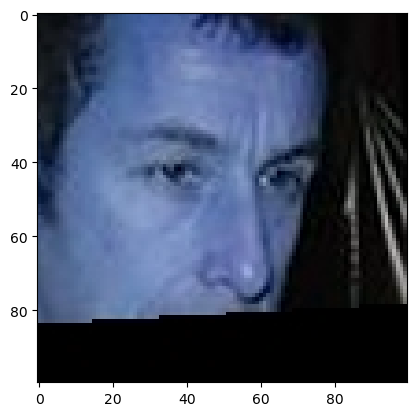

In [24]:
# Visualizing the sample image
plt.imshow(img)

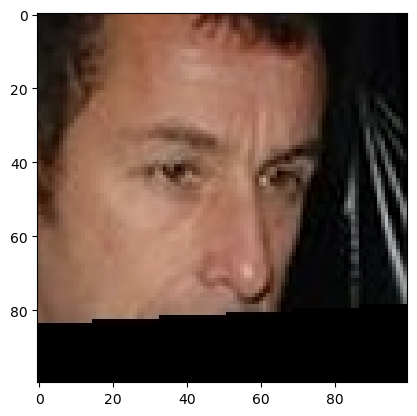

In [25]:
# Since the color channels are in different order, channels need to be reorganized from BGR to RGB.
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_RGB)

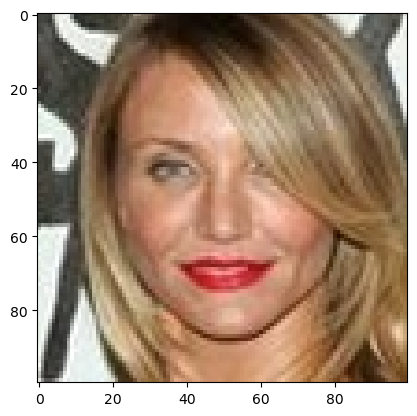

In [26]:
# Selecting another sample image for confirming the channel order
img = cv2.imread(dataset_df.loc[500, 'image_pathname'])  # BGR
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert BGR to RGB
plt.imshow(img)

In [27]:
# Making sure the second image selected is also a 100x100 pixels image
img.shape

(100, 100, 3)

In [28]:
# Making sure the second image selected is also a 24-bit image
img.min(), img.max()

(0, 255)

# 2. Defining a Model and Preprocessing the Images

The objetive of this step is to define the model architecture, generate training/validation/testing samples and format the image according the requirements of the training strategy.

In [29]:
# Listing important libraries required for model definition and image preprocessing
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install Keras-Applications

filename = "/opt/conda/lib/python3.10/site-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))  #syntax update required for newer version of keras/tensorflow

import cv2

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from keras_vggface.vggface import VGGFace
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-5fdlr_zl
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-5fdlr_zl
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8315 sha256=f9caa0285a8a1f30e5efc9fc21afaadcfec33fa33dcbaaa04d065a4b514b0ff5
  Stored in directory: /tmp/pip-ephem-wheel-cache-xfny5bkw/wheels/62/cd/e0/3a2d2fe84d014324aed54d420cab52df65a774d9b296c63996
Successfully built keras-vggface
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.1 MB/s eta 0:00:00


## 2.1 Model Architecture

A transfer learning approach was adopted to optmize the training of the model. 

[VGGFace Resnet50](https://github.com/rcmalli/keras-vggface.git) was selected as the pre-trained (base) model for providing a superior performance on the face recognition task. Our original attempts to train a neural network from scratch using oversampling (5k samples per class) and multiprocessing has yelded a maximum accuracy of 52%. 

The VGGFace base model selected consists in an [Oxford VGGFace](https://www.robots.ox.ac.uk/~vgg/software/vgg_face/) implementation using Keras functional framework v2+. 

The original weights of the pre-trained model were maintained requiring images with a size of 224x224 pixels in the input layer.

A fully-connected network classifier was plugged into the base model. After some trial and error, the following optimal hyperparameters were defined for the plugged classification network:
* two hidden layers with 128 nodes and relu activation
* one output layer with 83 classes and softmax activation (since this is a multiclass problem)
* a dropout value of 0.3 has shown to be beneficial to control the overfitting 

In [30]:
# Based on RESNET50 architecture -> new paper(2017)
vggface = VGGFace(model='resnet50')


# Convolution Features
vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max

#custom parameters
nb_class = 83
hidden_dim = 128

vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = False
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
x = Dropout(0.3)(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
vggface_model = Model(vgg_model.input, out)




58909280/58909280 [==============================] - 2s 0us/step


In [31]:
# Print a summary of the model architecture
vggface_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

## 2.2 Creating the training/validation/testing datasets

Training, validation and testing samples were extracted from the profiled dataset at a rate of 0.8, 0.2 and 0.2, respectively. 

Since this is a multiclass problem, the classes contained in the dataset had to be encoded first and the class balance validated in each sample.

In [33]:
# Viewing the profiled image dataset
dataset_df

,image_pathname,class
0,../input/ifsp-d3apl-2023-face-recognition/trai...,Adam Sandler
1,../input/ifsp-d3apl-2023-face-recognition/trai...,Adam Sandler
2,../input/ifsp-d3apl-2023-face-recognition/trai...,Adam Sandler
3,../input/ifsp-d3apl-2023-face-recognition/trai...,Adam Sandler
4,../input/ifsp-d3apl-2023-face-recognition/trai...,Adam Sandler
...,...,...
4145,../input/ifsp-d3apl-2023-face-recognition/trai...,Zac Efron
4146,../input/ifsp-d3apl-2023-face-recognition/trai...,Zac Efron
4147,../input/ifsp-d3apl-2023-face-recognition/trai...,Zac Efron
4148,../input/ifsp-d3apl-2023-face-recognition/trai...,Zac Efron


In [34]:
# Building an array of unique classes
dataset_df["class"].unique()

array(['Adam Sandler', 'Alec Baldwin', 'Angelina Jolie',
       'Anna Kournikova', 'Ashton Kutcher', 'Avril Lavigne',
       'Barack Obama', 'Ben Affleck', 'Beyonce Knowles', 'Brad Pitt',
       'Cameron Diaz', 'Cate Blanchett', 'Charlize Theron',
       'Christina Ricci', 'Claudia Schiffer', 'Clive Owen',
       'Colin Farrell', 'Colin Powell', 'Cristiano Ronaldo',
       'Daniel Craig', 'Daniel Radcliffe', 'David Beckham',
       'David Duchovny', 'Denise Richards', 'Drew Barrymore',
       'Dustin Hoffman', 'Ehud Olmert', 'Eva Mendes', 'Faith Hill',
       'George Clooney', 'Gordon Brown', 'Gwyneth Paltrow', 'Halle Berry',
       'Harrison Ford', 'Hugh Jackman', 'Hugh Laurie', 'Jack Nicholson',
       'Jennifer Aniston', 'Jennifer Lopez', 'Jennifer Love Hewitt',
       'Jessica Alba', 'Jessica Simpson', 'Joaquin Phoenix',
       'John Travolta', 'Julia Roberts', 'Julia Stiles', 'Kate Moss',
       'Kate Winslet', 'Katherine Heigl', 'Keira Knightley',
       'Kiefer Sutherland', 'Leo

In [35]:
# Veryfing the number of unique classes
class_names = sorted(dataset_df["class"].unique())
n_classes = len(class_names)

print(f'Number of classes: {n_classes}')
print(f'Classes: {class_names}')

Number of classes: 83
Classes: ['Adam Sandler', 'Alec Baldwin', 'Angelina Jolie', 'Anna Kournikova', 'Ashton Kutcher', 'Avril Lavigne', 'Barack Obama', 'Ben Affleck', 'Beyonce Knowles', 'Brad Pitt', 'Cameron Diaz', 'Cate Blanchett', 'Charlize Theron', 'Christina Ricci', 'Claudia Schiffer', 'Clive Owen', 'Colin Farrell', 'Colin Powell', 'Cristiano Ronaldo', 'Daniel Craig', 'Daniel Radcliffe', 'David Beckham', 'David Duchovny', 'Denise Richards', 'Drew Barrymore', 'Dustin Hoffman', 'Ehud Olmert', 'Eva Mendes', 'Faith Hill', 'George Clooney', 'Gordon Brown', 'Gwyneth Paltrow', 'Halle Berry', 'Harrison Ford', 'Hugh Jackman', 'Hugh Laurie', 'Jack Nicholson', 'Jennifer Aniston', 'Jennifer Lopez', 'Jennifer Love Hewitt', 'Jessica Alba', 'Jessica Simpson', 'Joaquin Phoenix', 'John Travolta', 'Julia Roberts', 'Julia Stiles', 'Kate Moss', 'Kate Winslet', 'Katherine Heigl', 'Keira Knightley', 'Kiefer Sutherland', 'Leonardo DiCaprio', 'Lindsay Lohan', 'Mariah Carey', 'Martha Stewart', 'Matt Damon'

In [36]:
# Number of samples per class
dataset_df['class'].value_counts()

Adam Sandler         50
Nicole Kidman        50
Miley Cyrus          50
Mickey Rourke        50
Michael Bloomberg    50
                     ..
Ehud Olmert          50
Dustin Hoffman       50
Drew Barrymore       50
Denise Richards      50
Zac Efron            50
Name: class, Length: 83, dtype: int64

In [37]:
# Labeling and creating the first stratified samples for training and testing
labels = dataset_df['class']

dataset_df_full_train, dataset_df_test = train_test_split(dataset_df, test_size=0.2, random_state=22, stratify=labels)

In [38]:
# Shape of the full training dataset
dataset_df_full_train.shape

(3320, 2)

In [39]:
# Head of the full training dataset
dataset_df_full_train.head()

,image_pathname,class
2273,../input/ifsp-d3apl-2023-face-recognition/trai...,Julia Stiles
2547,../input/ifsp-d3apl-2023-face-recognition/trai...,Kiefer Sutherland
842,../input/ifsp-d3apl-2023-face-recognition/trai...,Colin Farrell
4056,../input/ifsp-d3apl-2023-face-recognition/trai...,Will Smith
3288,../input/ifsp-d3apl-2023-face-recognition/trai...,Reese Witherspoon


In [40]:
# Shape of the testing dataset
dataset_df_test.shape

(830, 2)

In [41]:
# Labeling and creating the second stratified samples for the training and validation
labels_full_train = dataset_df_full_train['class']

dataset_df_train, dataset_df_val = train_test_split(dataset_df_full_train, train_size=0.8, random_state=22, stratify=labels_full_train)


In [42]:
# Checking class balancing in the training set
dataset_df_train['class'].value_counts()

Miley Cyrus           32
Stephen Colbert       32
Anna Kournikova       32
Christina Ricci       32
Renee Zellweger       32
                      ..
Cristiano Ronaldo     32
Scarlett Johansson    32
Faith Hill            32
Julia Stiles          32
Ehud Olmert           32
Name: class, Length: 83, dtype: int64

In [43]:
# Checking class balancing in the validation set
dataset_df_val['class'].value_counts()

Lindsay Lohan        8
Ben Affleck          8
Angelina Jolie       8
Barack Obama         8
Denise Richards      8
                    ..
Leonardo DiCaprio    8
Julia Stiles         8
John Travolta        8
Tom Cruise           8
George Clooney       8
Name: class, Length: 83, dtype: int64

In [44]:
# Checking class balancing in the testing set
dataset_df_test['class'].value_counts()

Joaquin Phoenix      10
Daniel Craig         10
Beyonce Knowles      10
Renee Zellweger      10
Kiefer Sutherland    10
                     ..
Anna Kournikova      10
Barack Obama         10
Steve Carell         10
George Clooney       10
David Beckham        10
Name: class, Length: 83, dtype: int64

## 2.3 Preprocessing the images

Each file of the original dataset provided is 24-bit image of 100x100 pixels in size. As the VGGFace model selected as the base model requires images of 224x224 pixels, the profiled dataset was preprocessed for resizing. The images were also submitted to feature scaling and the image classes were properly encoded.

In [45]:
# Defininf a function for preprocess the images (resizing, scaling and enconding)
def preprocess_faces_dataset(dataset_df, label_encoder: LabelEncoder, new_img_dims, verbose=0):
    # load the images as a feature matrix
    image_list = []  # list of numpy arrays
    
    for index, img_path in enumerate(dataset_df['image_pathname']):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # image resizing
        # for gray or color images, the linear interpolation sounds good
        img = cv2.resize(img, new_img_dims, interpolation=cv2.INTER_LINEAR)        
        image_list.append(img)
        
        if verbose and (index % verbose) == 0:
            print(f'{index + 1}/{dataset_df.shape[0]} - {img_path}')
    
    # numpy array 4D: n_imgs, height, width, n_channels
    X = np.array(image_list)
    
    # feature scaling
    # numpy arary 4D with values within [0, 1]
    X = X / 255.0
    
    # encoding the classes
    # numpy array 1D with integer labels
    y = label_encoder.transform(dataset_df['class'])
    
    return X, y

In [46]:
# training a Label Encoder from the train set
label_encoder = LabelEncoder()
label_encoder.fit(dataset_df_train['class'])

label_encoder.classes_

array(['Adam Sandler', 'Alec Baldwin', 'Angelina Jolie',
       'Anna Kournikova', 'Ashton Kutcher', 'Avril Lavigne',
       'Barack Obama', 'Ben Affleck', 'Beyonce Knowles', 'Brad Pitt',
       'Cameron Diaz', 'Cate Blanchett', 'Charlize Theron',
       'Christina Ricci', 'Claudia Schiffer', 'Clive Owen',
       'Colin Farrell', 'Colin Powell', 'Cristiano Ronaldo',
       'Daniel Craig', 'Daniel Radcliffe', 'David Beckham',
       'David Duchovny', 'Denise Richards', 'Drew Barrymore',
       'Dustin Hoffman', 'Ehud Olmert', 'Eva Mendes', 'Faith Hill',
       'George Clooney', 'Gordon Brown', 'Gwyneth Paltrow', 'Halle Berry',
       'Harrison Ford', 'Hugh Jackman', 'Hugh Laurie', 'Jack Nicholson',
       'Jennifer Aniston', 'Jennifer Lopez', 'Jennifer Love Hewitt',
       'Jessica Alba', 'Jessica Simpson', 'Joaquin Phoenix',
       'John Travolta', 'Julia Roberts', 'Julia Stiles', 'Kate Moss',
       'Kate Winslet', 'Katherine Heigl', 'Keira Knightley',
       'Kiefer Sutherland', 'Leo

In [47]:
# preprocessing the train set
X_train, y_train = preprocess_faces_dataset(dataset_df_train, label_encoder, new_img_dims=(224, 224))

In [48]:
# Visualizing the attributes of the processed training images
print(f'X_train.shape: {X_train.shape}')
print(f'y_train (classes): {np.unique(y_train)}')
print(f'y_train.shape: {y_train.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

X_train.shape: (2656, 224, 224, 3)
y_train (classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
y_train.shape: (2656,)
Min. value of X_train: 0.0
Max. value of X_train: 1.0



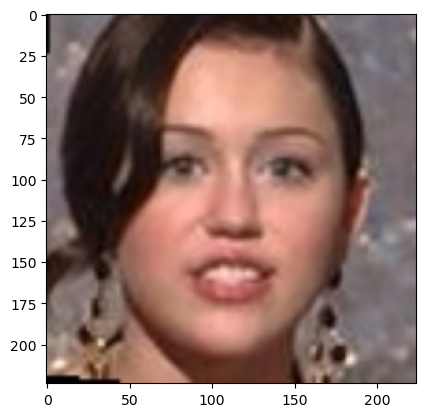

In [49]:
# Visualizing a sample processed training image
plt.imshow(X_train[0])

In [50]:
# Preprocessing the validation set
X_val, y_val = preprocess_faces_dataset(dataset_df_val, label_encoder, new_img_dims=(224, 224))

In [52]:
# Visualizing the attributes of the processed validation images
print(f'X_val.shape: {X_val.shape}')
print(f'y_val (classes): {np.unique(y_val)}')
print(f'y_val.shape: {y_val.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_val: {X_val.min()}')
print(f'Max. value of X_val: {X_val.max()}\n')


X_val.shape: (664, 224, 224, 3)
y_val (classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
y_val.shape: (664,)
Min. value of X_val: 0.0
Max. value of X_val: 1.0



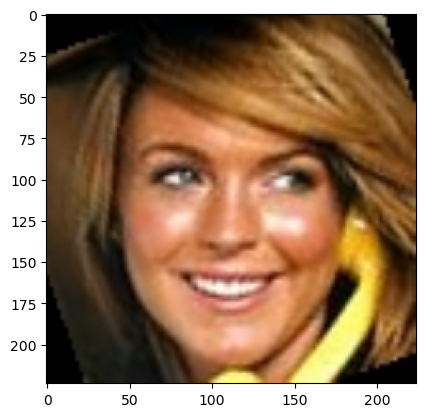

In [54]:
# Visualizing a sample processed validation image
plt.imshow(X_val[0])

In [55]:
# preprocessing the test set
X_test, y_test = preprocess_faces_dataset(dataset_df_test, label_encoder, new_img_dims=(224, 224))

In [56]:
# Visualizing the attributes of the processed testing images
print(f'X_test.shape: {X_test.shape}')
print(f'y_test (classes): {np.unique(y_test)}')
print(f'y_test.shape: {y_test.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_val: {X_test.min()}')
print(f'Max. value of X_val: {X_test.max()}\n')

X_test.shape: (830, 224, 224, 3)
y_test (classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
y_test.shape: (830,)
Min. value of X_val: 0.0
Max. value of X_val: 1.0



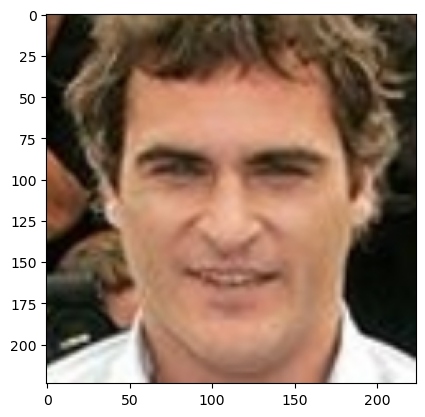

In [57]:
# Visualizing a sample processed testing image
plt.imshow(X_test[0])

In [58]:
# Saving the preprocessed data
out_dir = '../working/preprocessed'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
dataset_df_full_train.to_csv(os.path.join(out_dir, 'full_train.csv'), index=False)

dataset_df_train.to_csv(os.path.join(out_dir, 'train.csv'), index=False)
np.save(os.path.join(out_dir, 'train_data_224x224x3.npy'), X_train)
np.save(os.path.join(out_dir, 'train_labels.npy'), y_train)

dataset_df_val.to_csv(os.path.join(out_dir, 'validation.csv'), index=False)
np.save(os.path.join(out_dir, 'validation_data_224x224x3.npy'), X_val)
np.save(os.path.join(out_dir, 'validation_labels.npy'), y_val)

dataset_df_test.to_csv(os.path.join(out_dir, 'test.csv'), index=False)
np.save(os.path.join(out_dir, 'test_data_224x224x3.npy'), X_test)
np.save(os.path.join(out_dir, 'test_labels.npy'), y_test)


# 3. Training and fine-tuning the Model

The objetive of this step is to define the remaining hyperparameters of the model, train and validate the model and leverage the training history and validation results to fine-tune the model.

In [60]:
# Imports for training the model
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

## 3.1 Compiling and Training the Model

Before compiling the model, the following hyperparameters were defined:
* Sparce Categorical Cross-entropy was selected as the loss function since it automatically converts scalar-value lables into a one-hot vector in multiclass classification problems
* The optimization algorithm selected was [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/). 
* A learning rate of 0.0005 (originally a learning rate of 0.001 was selected but the model started to bounce around the minimum loss value)
* A maximum value of 20 epochs (originally the training was set to 100 epochs, but further inspection of the loss and accuracy graphs has shown that a lower number of epochs was suficient)
* A patience value of 3 was adopted (originally a value of 10 was set, but further inspection of the training history has shown that a smaller value would be more appropriate)
* The core model evaluation metric was accuracy since this is the main criteria established in the competition

In [61]:
vggface_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [62]:
# Defining optimization and loss hyperparameters
opt = Adam(learning_rate=0.0005)
vggface_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [63]:
# Defining early stopping criteria
early_stopping_cb = tensorflow.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [65]:
# Training the VGGFace model 
history = vggface_model.fit(X_train, y_train, epochs=20, batch_size=83, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])                  

Epoch 1/20
32/32 [==============================] - 21s 313ms/step - loss: 4.1451 - accuracy: 0.1028 - val_loss: 3.6506 - val_accuracy: 0.3373
Epoch 2/20
32/32 [==============================] - 8s 264ms/step - loss: 3.0254 - accuracy: 0.4160 - val_loss: 2.3987 - val_accuracy: 0.7229
Epoch 3/20
32/32 [==============================] - 7s 225ms/step - loss: 1.8505 - accuracy: 0.6898 - val_loss: 1.4014 - val_accuracy: 0.8735
Epoch 4/20
32/32 [==============================] - 8s 262ms/step - loss: 1.0631 - accuracy: 0.8475 - val_loss: 0.8761 - val_accuracy: 0.9232
Epoch 5/20
32/32 [==============================] - 7s 226ms/step - loss: 0.6923 - accuracy: 0.8934 - val_loss: 0.6531 - val_accuracy: 0.9292
Epoch 6/20
32/32 [==============================] - 8s 266ms/step - loss: 0.4453 - accuracy: 0.9469 - val_loss: 0.5163 - val_accuracy: 0.9398
Epoch 7/20
32/32 [==============================] - 7s 227ms/step - loss: 0.3410 - accuracy: 0.9616 - val_loss: 0.4348 - val_accuracy: 0.9443
Epoch

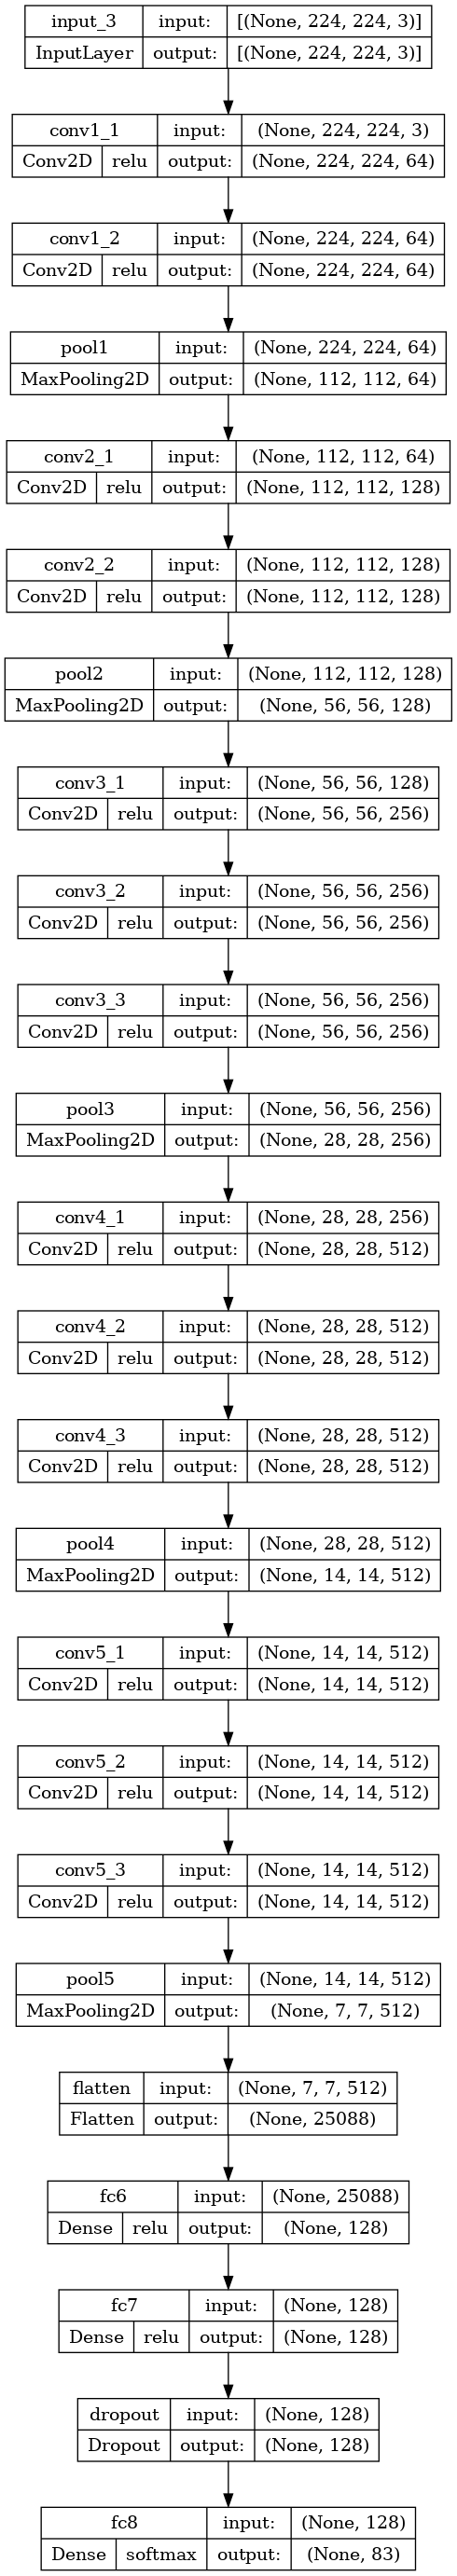

In [66]:
# Visualizing the VGGFace model
plot_model(vggface_model, show_shapes=True, show_layer_activations=True)

In [67]:
# Saving the trained model as a HDF5 file
vggface_model.save('../working/'+
    'transfer_learning_trained' +
    '_face_cnn_model.h5')

## 3.2 Visualizing the training history

Two graphs, for loss and accuracy, respectively, were plotted to assist with overfitting analaysis and hyperparameter fine-tuning.

In [68]:
# Building a dataframe for the training history data
history_df = pd.DataFrame(history.history)

Text(0, 0.5, 'Score')

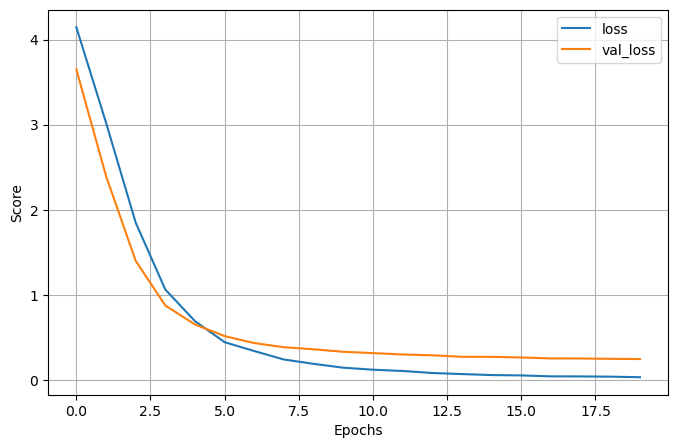

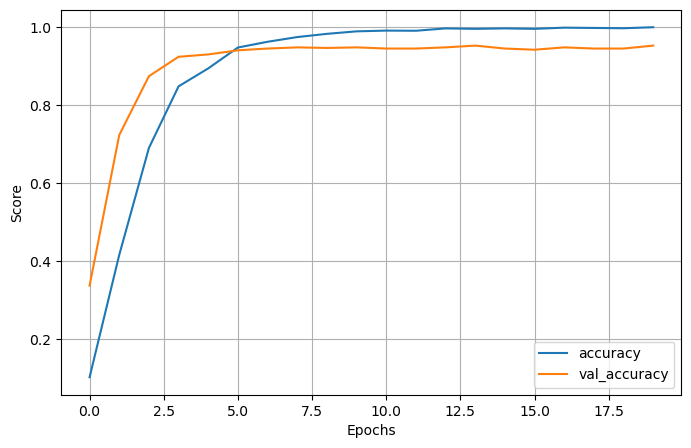

In [69]:
# Plotting the loss and accuracy graphs 
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

## 3.3 Model evaluation

The trained model was evaluated against the labeled test data with a focus on the accuracy of the results since this was the core assessment criteria for the competition.

In [70]:
# Evaluating the metrics of the model in test mode
vggface_model.evaluate(X_test, y_test)


26/26 [==============================] - 6s 143ms/step - loss: 0.2782 - accuracy: 0.9422


[0.27819955348968506, 0.942168653011322]

In [71]:
# Predicting the values of the testing data
y_test_proba = vggface_model.predict(X_test)
y_test_proba

26/26 [==============================] - 2s 65ms/step


array([[2.7139938e-08, 2.6504634e-07, 1.0891549e-06, ..., 7.2296007e-07,
        3.5991749e-07, 1.6170485e-05],
       [2.7645858e-06, 1.3085663e-05, 8.0981715e-07, ..., 5.8157138e-07,
        8.1715376e-07, 4.1307976e-06],
       [1.6210770e-06, 5.1198646e-07, 3.3824386e-03, ..., 2.0826162e-06,
        2.3204577e-05, 7.6060933e-05],
       ...,
       [1.6895914e-09, 8.7523794e-08, 2.1242083e-07, ..., 1.3149959e-07,
        6.0089116e-09, 3.7218438e-08],
       [3.2820550e-05, 1.9754402e-06, 5.0242984e-04, ..., 1.7092561e-05,
        7.6287579e-05, 2.2135105e-06],
       [2.1553488e-12, 1.4195406e-11, 2.4959751e-04, ..., 3.0507925e-07,
        7.8557783e-08, 6.7386303e-08]], dtype=float32)

In [72]:
# Establishing the predicted classes
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test_pred

array([42, 67, 47, 62,  5, 73, 42, 12, 34, 41, 17, 12, 67, 59, 82, 42, 17,
       81, 63, 23, 40, 33, 11, 18, 70, 61,  2, 77, 29, 33, 11, 76,  6,  3,
       61,  3, 53, 63, 25,  1, 53, 10, 18, 13, 12, 79, 33,  1, 69, 10, 20,
       44, 10, 28, 47, 51, 49, 33,  6, 27, 31, 67, 27, 73, 36, 18, 37, 49,
       72,  9,  7, 45, 48, 20, 57, 42, 68, 45, 43, 54, 49, 12,  3,  5, 15,
       27,  7, 61, 40, 63, 59, 64, 16, 67, 30,  7, 78, 54, 73, 50, 66, 69,
       13, 32, 19, 10, 12, 69, 49, 20, 71, 75, 13, 12, 40, 60, 15, 81, 63,
       44, 28, 48, 15, 66, 74, 67, 43, 37,  0, 20, 17, 80, 45, 76, 64, 29,
       12,  6, 47, 52, 26, 36, 19, 39, 26, 62, 34, 14, 45, 32, 14, 40, 64,
       56, 15, 79, 54, 14, 11, 62, 16, 72, 73, 31, 78, 69, 19, 47, 28, 81,
       46, 42, 49, 44, 14,  4,  3, 34, 60, 65, 25, 63, 52, 78, 16, 70, 36,
       42, 55, 64,  8, 15, 17, 14,  6, 35, 62, 29,  5, 32,  7, 59,  7, 78,
       30,  6, 68, 80, 81, 29, 22, 24, 41, 51, 44,  5, 17, 15, 22,  4, 40,
        8, 59, 56, 38, 23

In [73]:
# Generating a classification report
y_test = label_encoder.transform(dataset_df_test['class'])
class_names = label_encoder.classes_

print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

                      precision    recall  f1-score   support

        Adam Sandler       1.00      1.00      1.00        10
        Alec Baldwin       1.00      0.90      0.95        10
      Angelina Jolie       0.90      0.90      0.90        10
     Anna Kournikova       0.64      0.90      0.75        10
      Ashton Kutcher       1.00      1.00      1.00        10
       Avril Lavigne       0.91      1.00      0.95        10
        Barack Obama       1.00      1.00      1.00        10
         Ben Affleck       1.00      1.00      1.00        10
     Beyonce Knowles       1.00      0.90      0.95        10
           Brad Pitt       0.89      0.80      0.84        10
        Cameron Diaz       1.00      1.00      1.00        10
      Cate Blanchett       0.91      1.00      0.95        10
     Charlize Theron       0.71      1.00      0.83        10
     Christina Ricci       0.90      0.90      0.90        10
    Claudia Schiffer       1.00      1.00      1.00        10
       

# 4. Final Prediction and Concluding Remarks
An unlabeled dataset with 1,660 images was provided in the competition to be labeled by the VGGFace model trained. The unlabeled dataset was preprocessed to fit the requirements of the model, then predicted and finally submitted to the competition website.

In [ ]:
# Listing important libraries required for final prediction
import cv2

import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

import os

## 4.2 Preprocessing the Unlabeled Dataset

Before predicting the unlabeled dataset, the images had to be preprocessed so they could be resized to 224x224 pixels and a dataframe was created.

In [78]:
# Loading the unlabeled test dataset from the competition

test_folder = '../input/ifsp-d3apl-2023-face-recognition/test/test/'
img_test_list = sorted(os.listdir(test_folder))

img_test_full_paths = []


for img_test in img_test_list:
    full_img_test_path = os.path.join(test_folder, img_test)
    img_test_full_paths.append(full_img_test_path)

In [79]:
# Creating a dataframe to store the image full pathnames and their corresponding classes

dataset_sub_test = pd.DataFrame({
    'image_pathname': img_test_full_paths
   })

dataset_sub_test

,image_pathname
0,../input/ifsp-d3apl-2023-face-recognition/test...
1,../input/ifsp-d3apl-2023-face-recognition/test...
2,../input/ifsp-d3apl-2023-face-recognition/test...
3,../input/ifsp-d3apl-2023-face-recognition/test...
4,../input/ifsp-d3apl-2023-face-recognition/test...
...,...
1655,../input/ifsp-d3apl-2023-face-recognition/test...
1656,../input/ifsp-d3apl-2023-face-recognition/test...
1657,../input/ifsp-d3apl-2023-face-recognition/test...
1658,../input/ifsp-d3apl-2023-face-recognition/test...


In [80]:
# Counting the number of unlabeled images
dataset_sub_test['image_pathname'].value_counts()

../input/ifsp-d3apl-2023-face-recognition/test/test/0001.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/1104.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/1114.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/1113.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/1112.jpg    1
                                                               ..
../input/ifsp-d3apl-2023-face-recognition/test/test/0551.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/0550.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/0549.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/0548.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/1660.jpg    1
Name: image_pathname, Length: 1660, dtype: int64

In [83]:
# Defining a function to preprocess the unlabeled dataset

def preprocess_faces_unlabeled_dataset(dataset_df, new_img_dims, verbose=0):
    # load the images as a feature matrix
    image_list = []  # list of numpy arrays
    
    for index, img_path in enumerate(dataset_df['image_pathname']):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # image resizing
        # for gray or color images, the linear interpolation sounds good
        img = cv2.resize(img, new_img_dims, interpolation=cv2.INTER_LINEAR)        
        image_list.append(img)
        
        if verbose and (index % verbose) == 0:
            print(f'{index + 1}/{dataset_df.shape[0]} - {img_path}')
    
    # numpy array 4D: n_imgs, height, width, n_channels
    X = np.array(image_list)
    
    # feature scaling
    # numpy arary 4D with values within [0, 1]
    X = X / 255.0
   
   
    return X


In [84]:
# Preprocessing the unlabeled images
x_test=preprocess_faces_unlabeled_dataset(dataset_sub_test, new_img_dims=(224, 224))
x_test

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [85]:
# Saving the unlabeled dataset

out_dir = '../working/preprocessed'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
dataset_sub_test.to_csv(os.path.join(out_dir, 'sub_test.csv'), index=False)
np.save(os.path.join(out_dir, 'test_data_224x224x3.npy'), x_test)


## 4.2 Predicting the Classes

Based on the VGGFace model trained, the unlabeled test dataset from the competition was submitted for prediction.

In [ ]:
# Predicting the classes of the unlabeled dataset
y_test_proba = vggface_model.predict(x_test)
y_test_proba

In [ ]:
# Predicting the classes of the unlabeled dataset
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test_pred

In [ ]:
# Predicting the classes of the unlabeled dataset
len(y_test_pred)

## 4.3 Building the submission file

As a requirement from the competition rules, a submission file with 1,660 entries and two columns was required:

1. image-id: Id from the classified image (corresponds to the original image filename).
1. prediction: Name of the celebrity.

In [ ]:
# Inverse enconding the classes predicted

le = preprocessing.LabelEncoder()
class_names = label_encoder.classes_

le_fitted = le.fit_transform(class_names)

inverted = le.inverse_transform(y_test_pred)

print(inverted)
len(inverted)

In [ ]:
# Building an array for the first column of the submission file
image_id=list(range(1661))
image_id.pop(0)
len(image_id)

In [ ]:
# Building a dataframe forthe submission file
dataset_submission = pd.DataFrame({
    'image-id': image_id,
    'prediction': inverted
   })

dataset_submission

In [ ]:
# Saving the submission file as a .csv file
dataset_submission.to_csv('../working/final_prediction.csv', index=False)

# 5. Discussion and Next Steps

The trained model has generated an approximately 95% acuracy level on the unlabeled test dataset provided in the competition. 

Although it can be considered a good initial value, there are additional strategies that could be attempted to further improve the model. These are listed below in order of importance according to the opinion of the authors of this notebook:

1. Manage memory consumption: Perhaphs the biggest challenge so far was managing the consumption of RAM from the kernel. Altough 13Gb were made available in the session, the notebook would frequently cause the session to crash by exausthing the total memory. This factor has limited the amount of data passed to the model for training purposes, putting a hard limit in the accuracy of the model. Therefore, the primary suggestion for further improving this notebook would be to adopt an strategy to more efficiently manage RAM consumption.
2. Incorporate multi-processing: Related to the previous bullet item, the implementation of multi-processing could be the first major improvement of this notebook. Multi-processing had been initially incorporated into the VGG16 model, which has allowed oversampling and the model to be trained with up to 5000 samples for each class. However, VGGFace has proven to be a more accurate pre-trained model than VGG16 and therefore multi-processing still needs to be implemented for VGGFace.
3. Oversampling: Once memory consumption is addressed by multi-processing, another recommendation would be to leverage oversampling as an strategy to train more dense network structures. An initial image generator was developed to handle the class imbalance by shearing/rotating/zooming the training images. However, this approach was abandoned due to the lack of multi-processing support for VGGFace and the constant memory consumption issues.